In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import xgboost as xgb
import lightgbm as lgb
import missingno as msno
import sklearn

print("xgboost version:", xgb.__version__)
print("lightgbm version:", lgb.__version__)
print("missingno version:", msno.__version__)
print("sklearn version:", sklearn.__version__)

xgboost version: 1.4.2
lightgbm version: 3.3.0
missingno version: 0.5.0
sklearn version: 1.0


#### 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

#### (1) 데이터 가져오기

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')


train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

In [4]:
# train_df.head()
train_df['date2'] = train_df['date'].apply(lambda i: str(i[:6])).astype(int)
test_df['date2'] = test_df['date'].apply(lambda i: str(i[:6])).astype(int)
# test_df = test_df.drop('id')
train_df.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...        1180              0      1955   
1     1.0           0     0  ...         770              0      1933   
2     1.0           0     0  ...        1680              0      1987   
3     2.0           0     0  ...        1715              0      1995   
4     1.0           0     0  ...        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15   date2  
0             0    98178  47.5112 -122.257           1340        5650  201410  
1             0    98028  47.7379 -122.233           2720        8062  201502  
2             0    98074  47.6168 -122.045           1800        7503  201502  
3             0    98003  47.3097 -122.327           2238        6819  201406  
4             0    98198  47.4095 -122.315           1650        9711  201501  

[5 rows x 22 columns]

In [5]:
test_id = test_df['id']
test_df = test_df.drop(columns='date')
test_df.head()

id  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  15035         3       2.25         2570      7242     2.0           0   
1  15036         4       3.00         1960      5000     1.0           0   
2  15037         4       4.50         5420    101930     1.0           0   
3  15038         3       1.00         1780      7470     1.0           0   
4  15039         3       2.50         1890      6560     2.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        2170            400      1951          1991   
1     0          5      7        1050            910      1965             0   
2     0          3     11        3890           1530      2001             0   
3     0          3      7        1050            730      1960             0   
4     0          3      7        1890              0      2003             0   

   zipcode      lat     long  sqft_living15  sqft_lot15   date2  
0    98125  47.7210 -122.319           1690        7639  201412  
1    98136  47.5208 -122.393           1360        5000  201412  
2    98053  47.6561 -122.005           4760      101930  201405  
3    98146  47.5123 -122.337           1780        8113  201504  
4    98038  47.3684 -122.031           2390        7570  201503

In [6]:
print(train_df.shape, test_df.shape)

(15035, 22) (6468, 20)


#### 결측치 확인

In [7]:
train_df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
date2            0
dtype: int64

In [8]:
test_df.isnull().sum()

id               0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
date2            0
dtype: int64

#### 데이터 분포 확인

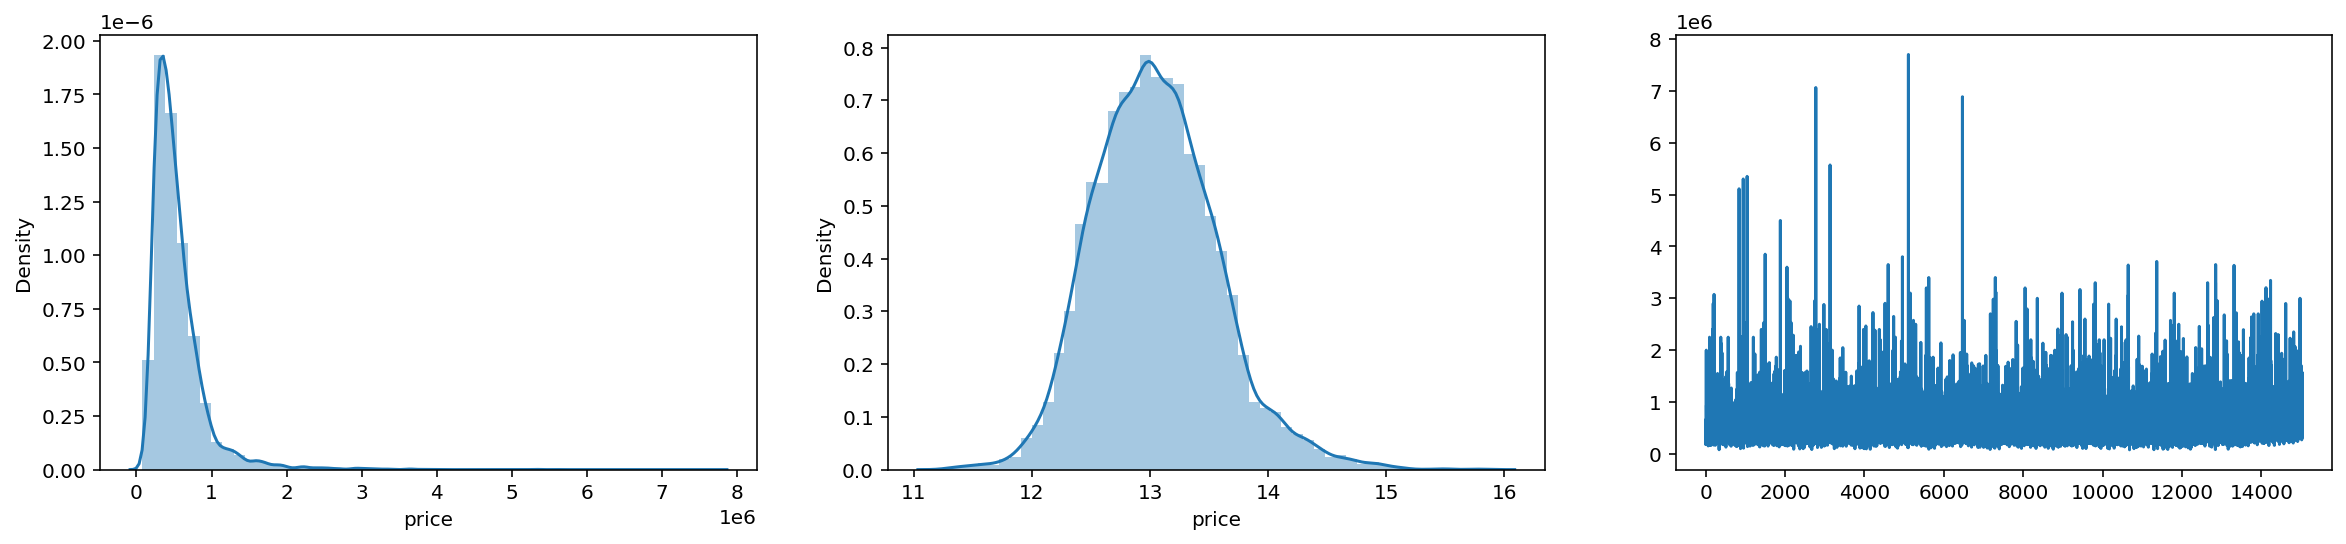

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(20,4))
sns.distplot(train_df['price'], ax=ax[0])   # price대신 다른 column 이입 가능
sns.distplot(np.log1p(train_df['price']), ax=ax[1]) # price대신 다른 column 이입 가능
train_df['price'].plot(ax=ax[2]) # price대신 다른 column 이입 가능
plt.show()

#### EDA

#### price와 상관관계 확인

In [10]:
train_corr = train_df.corr()
train_corr

id     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
id             1.000000  0.020899  0.010520   0.104030     0.041725 -0.034077   
price          0.020899  1.000000  0.323672   0.525479     0.702899  0.096793   
bedrooms       0.010520  0.323672  1.000000   0.530548     0.596974  0.033475   
bathrooms      0.104030  0.525479  0.530548   1.000000     0.755853  0.089308   
sqft_living    0.041725  0.702899  0.596974   0.755853     1.000000  0.176500   
sqft_lot      -0.034077  0.096793  0.033475   0.089308     0.176500  1.000000   
floors         0.182848  0.262588  0.189532   0.508649     0.363193  0.001535   
waterfront    -0.011775  0.265738 -0.004819   0.075452     0.108137  0.025584   
view          -0.024360  0.400806  0.085703   0.187488     0.282821  0.080441   
condition     -0.101618  0.039740  0.034885  -0.125907    -0.054213 -0.002099   
grade          0.078622  0.667211  0.375286   0.666278     0.762543  0.119906   
sqft_above     0.073086  0.608577  0.494867   0.688255     0.878736  0.186242   
sqft_basement -0.050634  0.322218  0.315183   0.282642     0.434017  0.017818   
yr_built       0.202477  0.047290  0.158799   0.503964     0.315927  0.058686   
yr_renovated  -0.029810  0.140808  0.022729   0.065423     0.064893 -0.001451   
zipcode       -0.005761 -0.051498 -0.162081  -0.207500    -0.200745 -0.127709   
lat            0.002588  0.301604 -0.011190   0.018110     0.051609 -0.082234   
long           0.014757  0.023547  0.135802   0.227669     0.245429  0.227451   
sqft_living15  0.029248  0.586419  0.407394   0.573541     0.760271  0.147562   
sqft_lot15    -0.032269  0.086384  0.027242   0.088120     0.184176  0.728458   
date2         -0.013261  0.007717 -0.002696  -0.022810    -0.022119  0.007500   

                 floors  waterfront      view  condition  ...  sqft_above  \
id             0.182848   -0.011775 -0.024360  -0.101618  ...    0.073086   
price          0.262588    0.265738  0.400806   0.039740  ...    0.608577   
bedrooms       0.189532   -0.004819  0.085703   0.034885  ...    0.494867   
bathrooms      0.508649    0.075452  0.187488  -0.125907  ...    0.688255   
sqft_living    0.363193    0.108137  0.282821  -0.054213  ...    0.878736   
sqft_lot       0.001535    0.025584  0.080441  -0.002099  ...    0.186242   
floors         1.000000    0.031159  0.034511  -0.261016  ...    0.529476   
waterfront     0.031159    1.000000  0.389669   0.011613  ...    0.081968   
view           0.034511    0.389669  1.000000   0.045255  ...    0.172693   
condition     -0.261016    0.011613  0.045255   1.000000  ...   -0.152856   
grade          0.462598    0.088061  0.247924  -0.143599  ...    0.759240   
sqft_above     0.529476    0.081968  0.172693  -0.152856  ...    1.000000   
sqft_basement -0.239350    0.071576  0.265880   0.175064  ...   -0.048623   
yr_built       0.490436   -0.026523 -0.061670  -0.366590  ...    0.422431   
yr_renovated   0.009752    0.104168  0.107605  -0.062342  ...    0.031441   
zipcode       -0.059107    0.028632  0.089247   0.001106  ...   -0.258474   
lat            0.049004   -0.014772  0.005285  -0.015974  ...    0.001074   
long           0.126983   -0.037922 -0.073151  -0.110742  ...    0.347226   
sqft_living15  0.287125    0.091810  0.278267  -0.091407  ...    0.737795   
sqft_lot15    -0.010287    0.028255  0.076501  -0.003873  ...    0.194226   
date2         -0.020891   -0.001742  0.013986  -0.047028  ...   -0.019422   

               sqft_basement  yr_built  yr_renovated   zipcode       lat  \
id                 -0.050634  0.202477     -0.029810 -0.005761  0.002588   
price               0.322218  0.047290      0.140808 -0.051498  0.301604   
bedrooms            0.315183  0.158799      0.022729 -0.162081 -0.011190   
bathrooms           0.282642  0.503964      0.065423 -0.207500  0.018110   
sqft_living         0.434017  0.315927      0.064893 -0.200745  0.051609   
sqft_lot            0.017818  0.058686     -0.001451 -0.127709 -0.082234   
floors     

<AxesSubplot:>

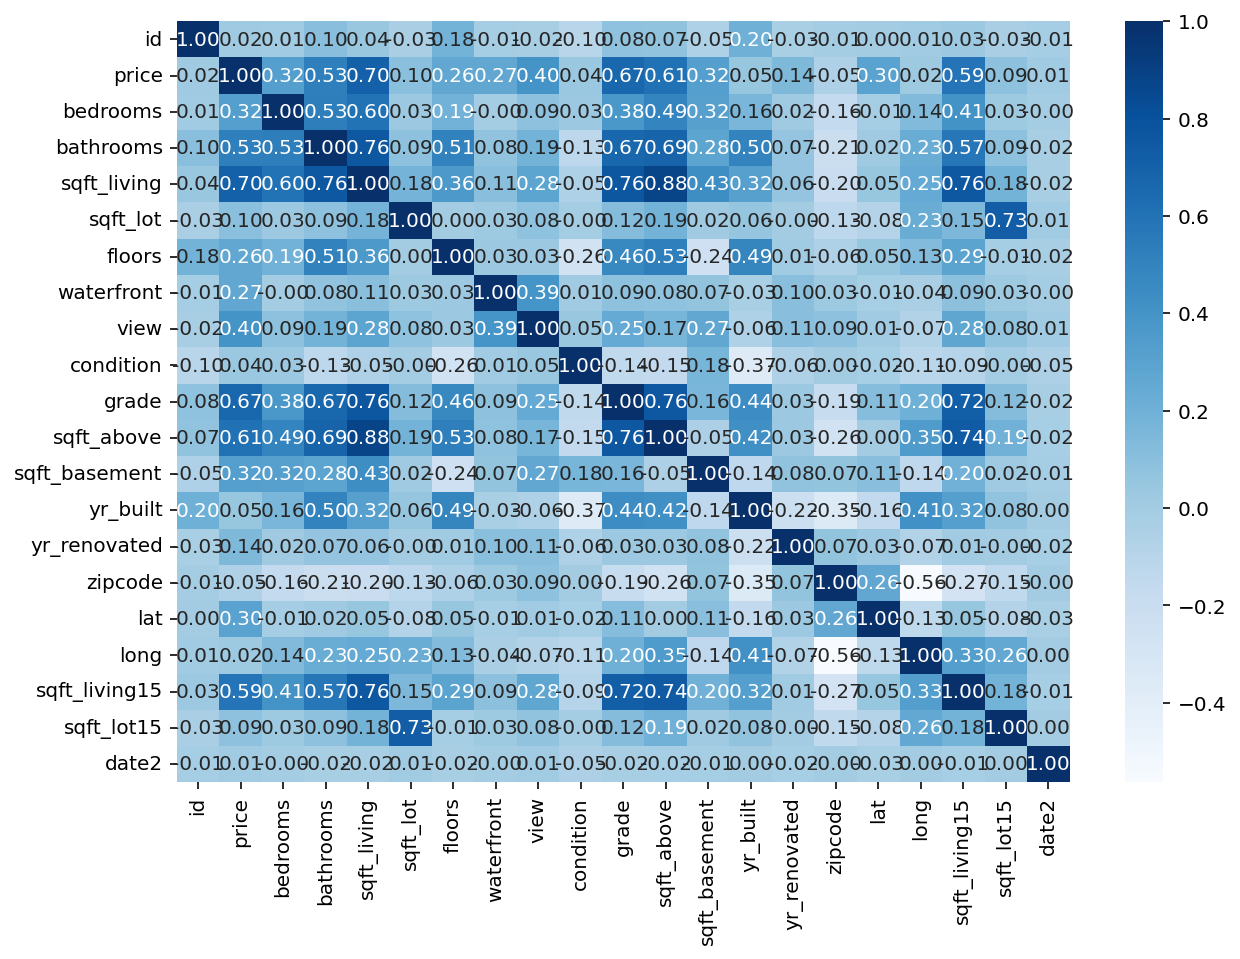

In [11]:
plt.figure(figsize=(10, 7))
sns.heatmap(train_corr, annot=True, fmt=".2f", cmap="Blues")

==> Price와 관련있는 feature: sqft_living > grade > sqft_above 

In [12]:
train = train_df.drop(columns=['date', 'price', 'id'])
y = train_df['price']
train.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0         3       1.00         1180      5650     1.0           0     0   
1         2       1.00          770     10000     1.0           0     0   
2         3       2.00         1680      8080     1.0           0     0   
3         3       2.25         1715      6819     2.0           0     0   
4         3       1.50         1060      9711     1.0           0     0   

   condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0          3      7        1180              0      1955             0   
1          3      6         770              0      1933             0   
2          3      8        1680              0      1987             0   
3          3      7        1715              0      1995             0   
4          3      7        1060              0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15   date2  
0    98178  47.5112 -122.257           1340        5650  201410  
1    98028  47.7379 -122.233           2720        8062  201502  
2    98074  47.6168 -122.045           1800        7503  201502  
3    98003  47.3097 -122.327           2238        6819  201406  
4    98198  47.4095 -122.315           1650        9711  201501

In [13]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

In [14]:
test_df = test_df.drop(columns=['id'])
test_df

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0            3       2.25         2570      7242     2.0           0     0   
1            4       3.00         1960      5000     1.0           0     0   
2            4       4.50         5420    101930     1.0           0     0   
3            3       1.00         1780      7470     1.0           0     0   
4            3       2.50         1890      6560     2.0           0     0   
...        ...        ...          ...       ...     ...         ...   ...   
6463         3       1.75         1500     11968     1.0           0     0   
6464         3       2.00         1490      1126     3.0           0     0   
6465         3       2.50         1310      1294     2.0           0     0   
6466         2       0.75         1020      1350     2.0           0     0   
6467         3       2.50         1600      2388     2.0           0     0   

      condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0             3      7        2170            400      1951          1991   
1             5      7        1050            910      1965             0   
2             3     11        3890           1530      2001             0   
3             3      7        1050            730      1960             0   
4             3      7        1890              0      2003             0   
...         ...    ...         ...            ...       ...           ...   
6463          3      6        1500              0      2014             0   
6464          3      8        1490              0      2014             0   
6465          3      8        1180            130      2008             0   
6466          3      7        1020              0      2009             0   
6467          3      8        1600              0      2004             0   

      zipcode      lat     long  sqft_living15  sqft_lot15   date2  
0       98125  47.7210 -122.319           1690        7639  201412  
1       98136  47.5208 -122.393           1360        5000  201412  
2       98053  47.6561 -122.005           4760      101930  201405  
3       98146  47.5123 -122.337           1780        8113  201504  
4       98038  47.3684 -122.031           2390        7570  201503  
...       ...      ...      ...            ...         ...     ...  
6463    98010  47.3095 -122.002           1320       11303  201406  
6464    98144  47.5699 -122.288           1400        1230  201501  
6465    98116  47.5773 -122.409           1330        1265  201502  
6466    98144  47.5944 -122.299           1020        2007  201406  
6467    98027  47.5345 -122.069           1410        1287  201501  

[6468 rows x 19 columns]

In [15]:
print(train.shape, test_df.shape, y.shape)

(15035, 19) (6468, 19) (15035,)


### 모델 build

In [16]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
#         mean_suqred_error(np.expm1(y_test). np.expm1(y_pred))

In [17]:
random_state = 2023

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = xgb.XGBRegressor(n_estimators=500, learning_rate=0.2, max_depth=4, random_state=random_state)
lightgbm = lgb.LGBMRegressor(random_state=random_state)
models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]
print('gogo')

gogo


In [18]:
def get_cv_score(models, x, y):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
# print('gogo')
get_cv_score(models, train, y)

Model: GradientBoosting, CV score:0.8608
Model: XGBoost, CV score:0.8961
Model: LightGBM, CV score:0.8818


In [19]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)
print('gogo')

gogo


In [20]:
y_pred = AveragingBlending(models, train, y, test_df)
sub = pd.DataFrame(data={'id':test_id,'price':y_pred})
sub.to_csv('submission.csv', index=False)

### 이하 모델의 하이퍼파라미터를 찾기 위한 모델 핏

In [21]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # 1. GridSearchCV 모델로 `model`을 초기화합니다.
    # model = LGBMRegressor(random_state=random_state)
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                            cv=5, verbose=1, n_jobs=5)
    # 2. 모델을 fitting 합니다.
    grid_model.fit(train, y)

    # 3. params, score에 각 조합에 대한 결과를 저장합니다.
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    # 4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
    results['RMSLE'] = np.sqrt(-1*results['score'])
    results = results.sort_values('RMSLE')

    return results

In [22]:
param_grid = {
    'n_estimators': [500], # n_estimator를 크게 잡는 경우가 많았다
    'max_depth': [10],  # depth를 굳이 깊이 잡는 것 같지 않았다
    'learning_rate': [0.1] #learning rate은 0.1로 선택
}

In [23]:
model = GradientBoostingRegressor(random_state = random_state)

In [25]:
# 시간이 오래걸려서 임시로 주석처리함
# my_GridSearch(model, train, y, param_grid, verbose=1, n_jobs=1)

In [ ]:
# def save_submission(model, train, y, test, model_name, rmsle=None):

#     model.fit(train, y)
#     prediction = model.predict(test)
#     prediction = np.expm1(prediction)
#     data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
#     submission_path = join(data_dir, 'submission.csv')
#     submission = pd.read_csv(submission_path)
#     submission['price'] = prediction
#     submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
#     submission.to_csv(submission_csv_path, index=False)
#     print('{} saved~!'.format(submission_csv_path))

In [ ]:
# save_submission(model, train, y, test_df, xgboost)